In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
try:
  !pip install faiss-cpu --no-cache
  print('Installed')
except:
  print('failed')

     |████████████████████████████████| 8.5 MB 5.4 MB/s 
Installed


In [ ]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3251, in <module>
    @_call_aside
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3235, in _call_aside
    f(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3279, in _initialize_master_working_set
    for dist in working_set
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3279, in <genexpr>
    for dist in working_set
  File "/usr/local/lib/python3.7/dist

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

2021-12-04 15:40:45.950426: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
!unzip '/content/drive/MyDrive/Input.zip' -d '/content/drive/MyDrive/Images/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Images/Input/img 42099img_00000014.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 4209img_00000047.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 420img_00000079.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42100img_00000015.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42101img_00000016.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42102img_00000017.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42103img_00000018.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42104img_00000019.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42105img_00000020.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42106img_00000021.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42107img_00000022.jpg  
  inflating: /content/drive/MyDrive/Images/Input/img 42108img_00000023.jpg  
  inflating: /content/drive/

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/content/drive/MyDrive/Images/'
filenames = sorted(get_file_list(root_dir))

In [ ]:
import glob
img_lst = []
image_paths = glob.glob('/content/drive/MyDrive/Images/Input/*.jpg')
for image_path in image_paths:
    img_lst.append(image_path)

In [ ]:
#Sampling the dataset, as the program takes a lot of time to run
imglist = img_lst[:1000]

In [ ]:
feature_list = []
for i in tqdm_notebook(range(len(imglist))):
    feature_list.append(extract_features(imglist[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
features=np.array(feature_list)
features.shape

(1000, 100352)

In [ ]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [ ]:
nprobe = 1  # find 2 most similar clusters
n_query = 1000
k = 10  # return 3 nearest neighbours
np.random.seed(0)   

In [ ]:
def faiss_similarity(img):
  feature_list=extract_features('/content/drive/MyDrive/Images/Input/'+str(img), model)
  nprobe = 2  # find 2 most similar clusters
  n_query = 1  
  print(feature_list)
  k = 10  # return 10 nearest neighbours
  np.random.seed(0)
  dimensions=len(feature_list)   
  query_vectors = np.random.random((n_query, dimensions)).astype('float32')
  distances, indices = index.search(feature_list.reshape(1,-1), k)
  list_ind=indices.flatten().tolist()
  f, ax = plt.subplots(1, 10, figsize=(16, 8))
  for i,j in enumerate(list_ind):
    ax[i].imshow(plt.imread(imglist[j]))
    ax[i].set_axis_off()
  plt.show()

[0.         0.         0.         ... 0.00376579 0.         0.        ]


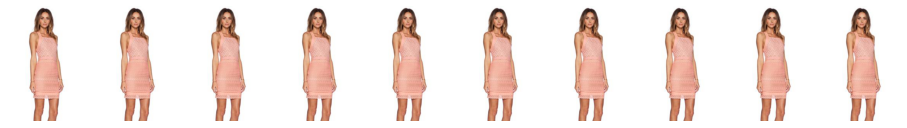

In [ ]:
faiss_similarity('img 120img_00000011.jpg')